# Data Analysis of Mental Health in the Tech Industry

In [62]:
# COVID-19 KOREA DATA ANALYSIS
# ----------------------------------------------------------------------------------------------------------------


# INITIATION ------------

# System information
import os

# Data preparation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skimage as ski
import seaborn as sns

# Data transformation & algorithms
import numpy as np
import scipy as sp
import sqlite3 as sql

# Data modeling
import sklearn as sk

# Miscellaneous
import math
from tabulate import tabulate
from processes import \
    preparation, \
    transformation, \
    cleaning, \
    visualization, \
    modeling

print(
    'CURRENT DIRECTORY:\n'
    '. = \"', os.getcwd(), '\"', sep=''
)

for dirName, _, filenames in os.walk('.'):
    if dirName[2:3] != '.':
        print('\n', dirName, sep='')
        for filename in filenames:
            print(os.path.join(dirName, filename))


CURRENT DIRECTORY:
. = "G:\My Drive\Codes\.Projects\DS\Turing\2 Data Analysis\S1\Project"

.
.\215.ipynb
.\.gitignore
.\LICENSE
.\README.md
.\DataAnalysis_MentalHealth.ipynb
.\requirements.txt
.\DataAnalysis_MentalHealth - Copy.ipynb

.\processes
.\processes\preparation.py
.\processes\transformation.py
.\processes\visualization.py
.\processes\modeling.py
.\processes\cleaning.py

.\processes\__pycache__
.\processes\__pycache__\preparation.cpython-311.pyc
.\processes\__pycache__\transformation.cpython-311.pyc
.\processes\__pycache__\cleaning.cpython-311.pyc
.\processes\__pycache__\visualization.cpython-311.pyc
.\processes\__pycache__\modeling.cpython-311.pyc

.\processes\tools
.\processes\tools\modify_cls.py

.\processes\tools\__pycache__
.\processes\tools\__pycache__\modify_cls.cpython-311.pyc

.\data
.\data\mental_health.sqlite
.\data\PossibleAnswers.txt
.\data\mental_health.sqlite-journal


## Familiarization with the Data

I will use the pandas library to load the data into a DataFrame and explore its shape, columns, and summary
statistics. This will help us identify any potential issues with the data quality, such as missing values, outliers, or incorrect formats. We will also visualize some key variables using matplotlib and seaborn to gain insights into the distribution and relationships of the data.


In [2]:
# EXECUTION -------------

# Display plots directly in the notebook interface
%matplotlib inline

# Connect to database
con = sql.connect('./data/mental_health.sqlite')

# Convert Answer into dataframe
Answer = pd.read_sql('SELECT * FROM Answer', con)

# First 10 observations
Answer.head(10)


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
5,33,2014,6,1
6,35,2014,7,1
7,39,2014,8,1
8,42,2014,9,1
9,23,2014,10,1


In [3]:
# Convert Question into dataframe
Question = pd.read_sql('SELECT * FROM Question', con)

# First 10 observations
Question.head(10)


,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
5,Do you have a family history of mental illness?,6
6,Have you ever sought treatment for a mental he...,7
7,How many employees does your company or organi...,8
8,Is your employer primarily a tech company/orga...,9
9,Does your employer provide mental health benef...,10


In [4]:
# Convert dataset into dataframe
Survey = pd.read_sql('SELECT * FROM Survey', con)

# First observations
Survey


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


### Improving Readability
One of the steps in data analysis is to improve the readability and format of the dataset.

For the numerical data, I will assign the 'date & time' columns with `datetime` data type for further effective data
manipulation.
Furthermore, for the categorical data, I will standardize several of these columns when they can be
considered to be (at least) ordinal variables.

By improving the readability and format of the dataset, we can enhance the quality and clarity of the data analysis. We can also save time and space when performing operations on the data.


In [5]:
# Improve Dataset's Readability & Reformat Numerical & Categorical Data
Survey['Description'] = 'Mental Health Survey for ' + Survey['SurveyID'].astype(str).str[:]
Question.rename(columns={'questiontext': 'QuestionText', 'questionid': 'QuestionID'}, inplace=True)


print('# Categorical data are simplified and reformatted')
print('# Numerical values for appropriate levels are assigned.')


# Categorical data are simplified and reformatted
# Numerical values for appropriate levels are assigned.


In [6]:
Answer.update_cols()
Answer.recap()


Number of Observations: 236898; 
Number of Features: 4.
- Categorical features: AnswerText; 
- Numerical features: SurveyID, UserID, QuestionID.


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
5,33,2014,6,1
6,35,2014,7,1
7,39,2014,8,1
8,42,2014,9,1
9,23,2014,10,1


## Data Cleaning
Before analyzing the Coursera dataset, some data cleaning steps will be performed to ensure the quality and validity of the data. In this section, we will describe the data cleaning process that we applied to the data.



First, any observations with erroneous values that are in unsuitable formats or missing values will be handled.

In [7]:
# HANDLING ERRONEOUS VALUES

# Cleaning the dataset
if Answer.has_nan() or Answer.has_na():
    ## Observations with erroneous non-numeric data such as Title, Organization, Certificate Type, and Difficulty are
    # removed;
    Answer.dropna(subset=''.split(', '), inplace=True)
    ## Due to limited number of observations, invalid numeric data are replaced with the variables' medians
    Answer.fillna(Answer.median(numeric_only=True, skipna=True), inplace=True)

if Question.has_nan() or Question.has_na():
    ## Observations with erroneous non-numeric data such as Title, Organization, Certificate Type, and Difficulty are
    # removed;
    Question.dropna(subset=''.split(', '), inplace=True)
    ## Due to limited number of observations, invalid numeric data are replaced with the variables' medians
    Question.fillna(value=Question['questionid'], inplace=True)

print('\n# All datasets no longer contain unrepresentable or missing data.')


Invalid values not found.
Missing values not found.
Invalid values not found.
Missing values not found.

# All datasets no longer contain unrepresentable or missing data.


Second, any duplicate samples and features based on IDs and names will be investigated further from the dataset to understand the reasons behind these duplicates and to avoid redundancy and bias.

In [8]:
# REMOVING DUPLICATE SAMPLES & FEATURES

# Remove duplicated IDs
ifDup_a = Answer.has_duplicates('index', rm=True)
ifDup_q = Question.has_duplicates('index', rm=True)


Duplicated IDs not found.
Duplicated IDs not found.


Third, any outliers in the numeric variables will be treated by observing boxplots and calculating the interquartile
range (IQR) for each variable. Any values that are more than 1.5 times the IQR above or below the first or third
quartile will be considered potential outliers which will require further careful treatment.

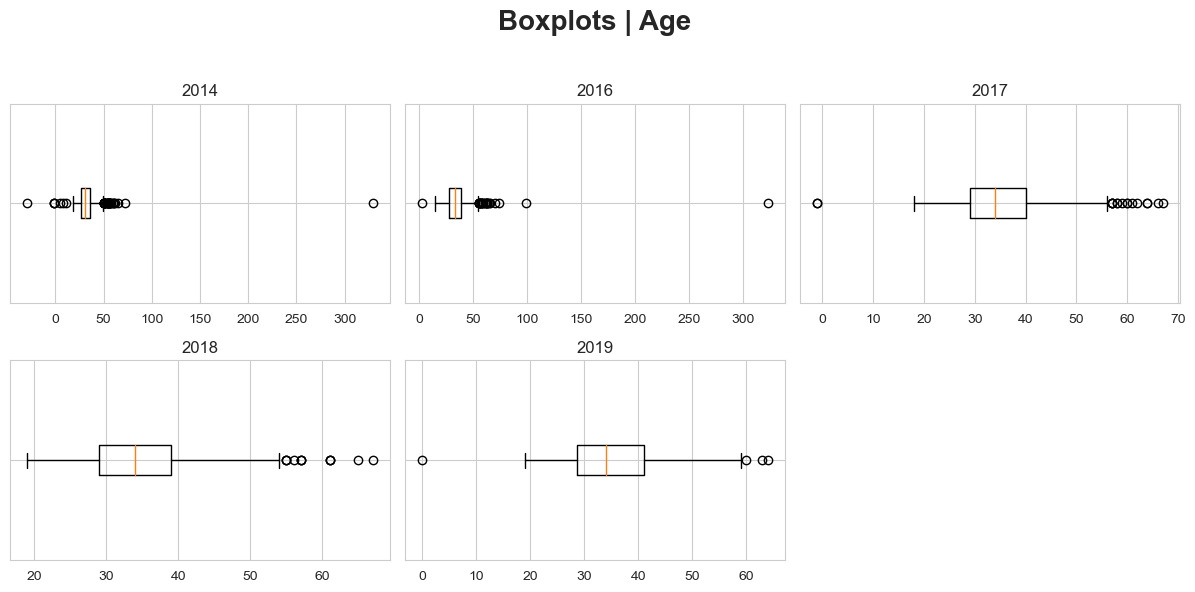

In [9]:
# TREATING OUTLIERS - AGE
con.execute(
    """
    -- Remove old Age dataset
    DROP TABLE IF EXISTS Age;
    """
)

con.execute(
    """
    -- Create Age dataset
    CREATE TABLE Age (
        UserID INTEGER,
        age INTEGER,
        SurveyID INTEGER
    )
    """
)

con.execute(
    """
    -- Insert values into Age
    INSERT INTO Age (UserID, age, SurveyID)
    SELECT UserID, CAST(AnswerText AS INTEGER), SurveyID
    FROM Answer
    WHERE QuestionID = 1
    """
)


def boxplots_age(years, xlim=None):
    n_cols = math.ceil(math.sqrt(len(years)))
    n_rows = math.ceil(len(years)/n_cols)

    # Create a figure with subplots
    figure, axes = plt.subplots(
        ncols=n_cols,
        nrows=n_rows,
        dpi=100,
        figsize=(min(16, 4*n_cols), min(12, 3*n_rows))
    )

    axes = np.array(axes).flatten()

    # Fill subplots with boxplots
    for i, year in enumerate(years):
        data = pd.read_sql(
            """
            SELECT age
            FROM Age
            WHERE SurveyID = '%s'
            """ % year,
            con
        )

        axes[i].boxplot(data, vert=False)
        axes[i].set_title(f'{year}', fontsize=12)
        axes[i].set_yticklabels([])
        if xlim is not None:
            axes[i].set_xlim(xlim)
        axes[i].grid(visible=True)

    # Remove the last empty subplot, adjust layout and title
    for i in range(len(years), len(axes)):
        figure.delaxes(axes[i])

    figure.suptitle(
        'Boxplots | Age\n',
        fontsize=20,
        fontweight='bold'
    )
    figure.subplots_adjust(hspace=0.2, wspace=0.2)
    figure.tight_layout()

    # Display the plot
    plt.show()


years = (2014, 2016, 2017, 2018, 2019)
boxplots_age(years)


In [10]:
# Inspect outliers for ages
## Loop through each column with outliers
for year in years:
    ### Compute IQR and select columns of interest
    data = Answer[(Answer['SurveyID'] == year) & (Answer['QuestionID'] == 1)].copy()
    data['AnswerText'] = pd.to_numeric(data['AnswerText'], errors='coerce')
    q1, q3 = data['AnswerText'].quantile((.25, .75))
    IQRange = q3 - q1
    cols = ['UserID','AnswerText']

    ### Select rows with values outside the IQR
    susValues = data[cols][(data['AnswerText'] < q1 - 1.5 * IQRange) | (data['AnswerText'] > q3 + 1.5 * IQRange)]

    ### Rearrange the 'outlier' rows based on data of interest
    susValues.sort_values('AnswerText', inplace=True, ascending=False)
    susValues.reset_index(drop=True, inplace=True)
    susValues.index += 1

    ### Display the outliers
    print(
        f"YEAR: {year}\n"
        f"{tabulate(susValues, tablefmt='simple')}\n"
        f"\n"
    )


YEAR: 2014
--  ----  ---
 1   365  329
 2  1183   72
 3   561   65
 4   521   62
 5   953   61
 6  1237   60
 7   298   60
 8   472   58
 9   476   57
10   644   57
11   467   57
12   632   56
13  1187   56
14   295   56
15   871   56
16   373   55
17   965   55
18   420   55
19   499   54
20   653   54
21   348   54
22   912   53
23   905   51
24  1160   51
25   528   51
26   857   51
27   896   51
28  1107   50
29   899   50
30   575   50
31   607   50
32   582   50
33    39   50
34  1091   11
35   990    8
36   735    5
37   716   -1
38  1128   -1
39   391   -1
40   144  -29
--  ----  ---


YEAR: 2016
--  ----  ---
 1  1825  323
 2  1633   99
 3  2378   74
 4  2482   70
 5  1962   66
 6  2146   65
 7  2006   63
 8  1569   63
 9  2161   63
10  2485   63
11  1852   62
12  1745   61
13  1780   61
14  1971   59
15  2133   59
16  1910   58
17  2387   57
18  1565   57
19  2428   57
20  1701   57
21  2586   56
22  1564   56
23  2327   56
24  2035   56
25  2690   56
26  1917    3
--  ----  

Any values of age that are below 15 and above 70 should be removed from the data.

In [11]:
# Remove invalid ages from Answer and store the updated answers in another table
con.execute(
    """
    -- Remove old Updated Answer dataset
    DROP TABLE IF EXISTS Answer_upd;
    """
)

con.execute(
    """
    -- Create Updated Answer dataset
    CREATE TABLE Answer_upd (
        AnswerText TEXT,
        SurveyID INTEGER,
        UserID INTEGER,
        QuestionID INTEGER
    )
    """
)

con.execute(
    """
    -- Insert values into Answer_upd
    INSERT INTO Answer_upd (AnswerText, SurveyID, UserID, QuestionID)
    SELECT *
    FROM Answer
    WHERE QuestionID <> 1 OR
    (CAST(AnswerText AS INTEGER) > 15 AND CAST(AnswerText AS INTEGER) < 70)
    """
)

# Update Answer df
Answer = pd.read_sql('SELECT * FROM Answer_upd', con)


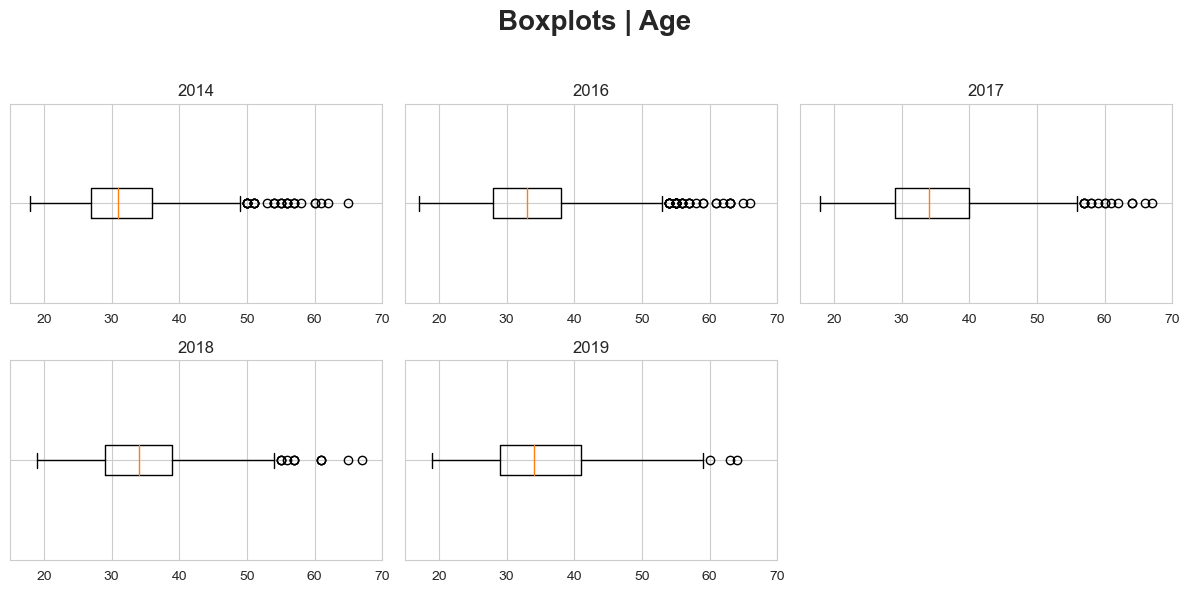

In [12]:
# Remove invalid ages from Age
con.execute(
    '''
    DELETE FROM Age
    WHERE age <= 15 OR age >= 70
    '''
)

# Show the updated boxplots after the removal
boxplots_age(years, xlim=(15, 70))


We will look into the distribution of ages more carefully using boxen plots (or letter-value plots).

A boxen plot is an enhanced version of the box plot that shows more details about the data distribution.
It uses a combination of box plots and kernel density estimation to display the distribution's shape more accurately, especially for large datasets or datasets with many outliers.

Therefore, they can reveal more information about the data's skewness, multi-modality, and tail behavior compared
to traditional box plots. As a result, they are more informative and provide a more detailed view of the data distribution, especially when the dataset has many data points or outliers. They can reveal subtle features of the data that might not be apparent in a standard box plot.

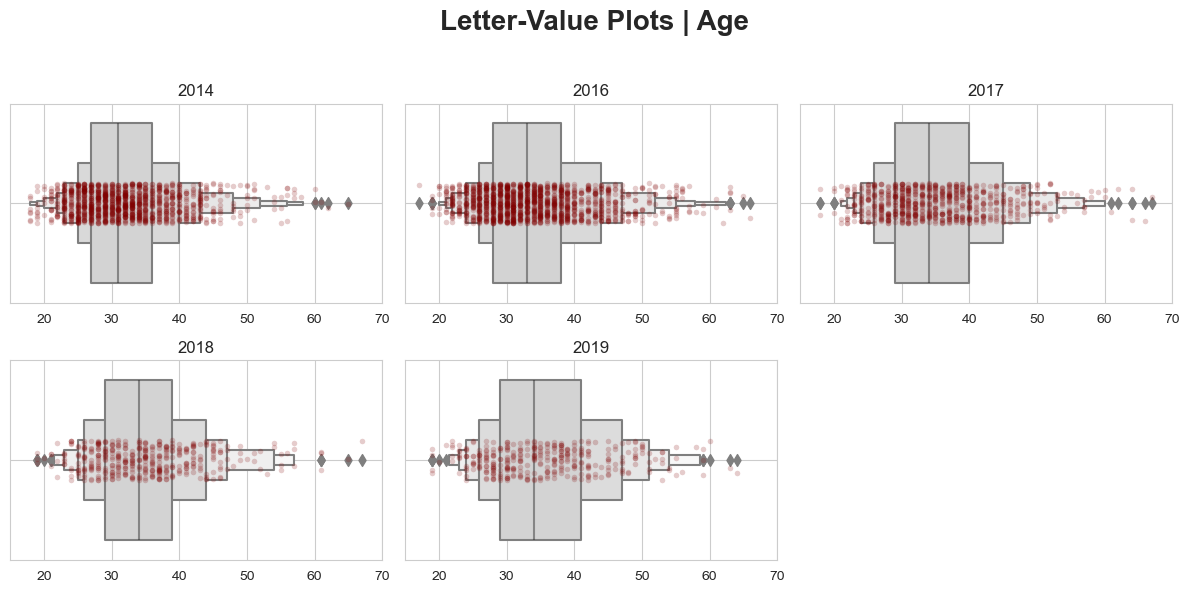

In [13]:
# Letter-value plots of quantitative data
n_cols = math.ceil(math.sqrt(len(years)))
n_rows = math.ceil(len(years)/n_cols)

# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=n_cols,
    nrows=n_rows,
    dpi=100,
    figsize=(min(16, 4*n_cols), min(12, 3*n_rows))
)

axes = np.array(axes).flatten()

# Fill subplots with boxenplots
for i, year in enumerate(years):
    data = pd.read_sql(
        """
        SELECT age
        FROM Age
        WHERE SurveyID = '%s'
        """ % year,
        con
    )

    sns.boxenplot(data['age'], ax=axes[i], color='lightgray', orient='h')
    sns.stripplot(data=data['age'], size=4, color='maroon', alpha=0.2, ax=axes[i], orient='h')
    axes[i].set_title(year, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_xlim(15, 70)
    axes[i].set_yticklabels([])
    axes[i].grid(visible=True)

# Remove the last empty subplot, adjust layout and title
for i in range(len(years), len(axes)):
    figure.delaxes(axes[i])

figure.suptitle(
    'Letter-Value Plots | Age\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


Now, we will inspect the possible values and the distribution of other answers.

In [14]:
def type_answers(id):
    answers = Answer['AnswerText'][Answer['QuestionID'] == id].unique()
    if sum(len(text) for text in answers)/len(answers) > 50:
        return '# Lengthy answers.'

    return answers

for i in Question['QuestionID'].unique()[1:]:
    print(
        f"{i}. {Question[Question['QuestionID'] == i].iloc[0, 0]}\n"
        f"---------------------------------------------------------------------------\n"
        f"{type_answers(i)}\n"
    )

2. What is your gender?
---------------------------------------------------------------------------
['Female' 'Male' 'Male-ish' 'Trans-female' 'something kinda male?'
 'queer/she/they' 'non-binary' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'queer' 'A little about you' 'p'
 'ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'fm' 'Transitioned, M2F'
 'Genderfluid (born female)' 'Other/Transfeminine'
 'Female or Multi-Gender Femme' 'Androgynous' 'male 9:1 female, roughly'
 '-1' 'Other' 'nb masculine' 'none of your business' 'genderqueer' 'Human'
 'Genderfluid' 'genderqueer woman' 'mtf' 'Queer' 'Fluid'
 'Male/genderqueer' 'Nonbinary' 'human' 'Unicorn' 'Male (trans, FtM)'
 'Genderflux demi-girl' 'female-bodied; no feelings about gender' 'AFAB'
 'Transgender woman' 'male' 'female' 'male/androgynous'
 'uhhhhhhhhh fem genderqueer?' 'God King of the Val

Regarding the gender data, we have decided to group the participants into 3 groups (Female, Male, and Mixed) for
several reasons, such as:
1. Data Consistency: By simplifying gender data into a limited set of categories, it ensures consistency and
standardization in the dataset.

2. Privacy and Ethics: Simplifying gender data can help in anonymizing the data and reducing the risk of reidentification.

3. Data Analysis: Aggregating gender data into a few categories allows for easier data analysis and comparison
between groups.

4. Sample Size: Combining these groups into a broader category, like "mixed," can help ensure statistical
significance when conducting analyses.

5. Overcoming Data Bias: This is a step towards addressing potential data bias and promoting inclusivity.

6. Interpretability: For communication and reporting purposes, simplifying gender data into a few categories makes
it easier for a broader audience to understand the findings and implications of the analysis.

In [15]:
# Update gender data in Updated Answer
con.execute(
    '''
    UPDATE Answer_upd
    SET AnswerText = CASE
        WHEN AnswerText LIKE 'female' THEN 'Female'
        WHEN AnswerText LIKE 'male' THEN 'Male'
        ELSE 'Mixed'
    END
    WHERE QuestionID = 2
    '''
)

# Update Answer df
Answer = pd.read_sql('SELECT * FROM Answer_upd', con)


We check to see if gender data has indeed been simplified

In [16]:
Answer['AnswerText'][Answer['QuestionID'] == 2].unique()

array(['Female', 'Male', 'Mixed'], dtype=object)

Because 'United States' and 'United States of America' represent the same country, we also combine both of these
answers under 1 label.

In [17]:
# Update residency data in Updated Answer
con.execute(
    '''
    UPDATE Answer_upd
    SET AnswerText = 'USA'
    WHERE QuestionID = 3 AND AnswerText LIKE 'United States%'
    '''
)

# Update Answer df
Answer = pd.read_sql('SELECT * FROM Answer_upd', con)


It also appears that -1 are used for participants' answers for various reasons. Some potential reasons are missing
 data, non-response or skipped questions, neutral responses, anonymization, consistency in data interpretation, or
  being a placeholder. In any case,we will retain these observations to avoid extreme loss of data and
  simplification of the data analysis.

## Exploratory Data Analysis

### Inspection into the survey questions over the years
From 2014 to 2016, although the questions used by the OSMI are similar for all demographic and personal
information in the beginning (first 12 questions), they differ in their contents in the following
mental-health-related questions.

In [18]:
# Questions that are used in all years ranging from year y to 2019
q = set(Answer[Answer['SurveyID']== 2019]['QuestionID'].unique())

for y in years[3::-1]:
    q = q.intersection(Answer[Answer['SurveyID']== y]['QuestionID'].unique())
    print(f"{y}-2019:\n"
          f"----------\n"
          f"{', '.join(map(str, q))}\n")


2018-2019:
----------
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89

2017-2019:
----------
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89

2016-2019:
----------
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 48, 49, 50, 51, 52, 53, 54, 55, 56

2014-2019:
----------
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12



Only data in the Survey in 2016 have questions that contain multiple answers, thus, there are multiple
observations for some set of users and questions.

In [19]:
Answer_2016mult = Answer[Answer['SurveyID'] == 2016].groupby(['UserID', 'QuestionID']).filter(lambda x: len(x) > 1)
Answer_2016mult.head(20)


,AnswerText,SurveyID,UserID,QuestionID
230324,"Anxiety Disorder (Generalized, Social, Phobia,...",2016,1262,115
230325,"Mood Disorder (Depression, Bipolar Disorder, etc)",2016,1262,115
230327,"Anxiety Disorder (Generalized, Social, Phobia,...",2016,1264,115
230328,"Mood Disorder (Depression, Bipolar Disorder, etc)",2016,1264,115
230329,"Anxiety Disorder (Generalized, Social, Phobia,...",2016,1265,115
230330,Stress Response Syndromes,2016,1265,115
230331,"Anxiety Disorder (Generalized, Social, Phobia,...",2016,1266,115
230332,Stress Response Syndromes,2016,1266,115
230333,Substance Use Disorder,2016,1266,115
230335,"Anxiety Disorder (Generalized, Social, Phobia,...",2016,1268,115


Those questions that have multiple answers are:

In [20]:
print(tabulate(Question[Question['QuestionID'].isin(Answer_2016mult['QuestionID'].unique())].set_index
               ('QuestionID')))

---  ---------------------------------------------------------
115  If yes, what condition(s) have you been diagnosed with?
116  If maybe, what condition(s) do you believe you have?
117  Which of the following best describes your work position?
---  ---------------------------------------------------------


In [21]:
Data = {
    y: Answer[Answer['SurveyID'] == y].pivot(index='UserID', columns='QuestionID', values='AnswerText')
    for y in years
    if y != 2016
}

Data[2016] = Answer[(Answer['SurveyID'] == 2016) & ~Answer['QuestionID'].isin([115, 116, 117])]\
    .pivot(index='UserID', columns='QuestionID', values='AnswerText')


QuestionID,1,2,3,4,5,6,7,8,9,10,...,107,108,109,110,111,112,113,114,118,Year
UserID,,,,,,,,,,,,,,,,,,,,,
1261,39,Male,United Kingdom,-1,0,No,0,26-100,1,Not eligible for coverage / NA,...,-1,Some of them,None of them,Some of my previous employers,I don't know,None of them,Maybe,"No, I don't think they would",Sometimes,2016
1262,29,Male,USA,Illinois,0,Yes,1,6-25,1,No,...,-1,None of them,None of them,"No, at none of my previous employers",Some did,None of them,"No, I don't think it would","No, I don't think they would",Never,2016
1263,38,Male,United Kingdom,-1,0,No,1,6-25,1,No,...,-1,I don't know,Some of them,Some of my previous employers,I don't know,Some of them,Maybe,Maybe,Always,2016
1264,43,Male,United Kingdom,-1,1,No,1,-1,-1,-1,...,I'm not sure,Some of them,Some of them,Some of my previous employers,I don't know,Some of them,"Yes, I think it would",Maybe,Sometimes,2016
1265,43,Female,USA,Illinois,0,Yes,1,6-25,0,Yes,...,-1,Some of them,Some of them,"No, at none of my previous employers",Some did,Some of them,"Yes, I think it would",Maybe,Sometimes,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,34,Female,USA,New York,1,Yes,1,-1,-1,-1,...,Not applicable to me,I don't know,None of them,Some of my previous employers,Some did,None of them,Maybe,Maybe,Sometimes,2016
2690,56,Male,USA,California,1,Yes,0,-1,-1,-1,...,No,-1,-1,-1,-1,-1,"No, it has not","Yes, I think they would",Sometimes,2016
2691,52,Male,USA,Georgia,0,Yes,1,100-500,1,Yes,...,-1,"Yes, all of them",Some of them,Some of my previous employers,None did,Some of them,"Yes, it has","No, I don't think they would",Sometimes,2016


In [36]:
Data[2016][2]

QuestionID,32,34
QuestionID,,
32,1.000000,0.719984
34,0.719984,1.000000


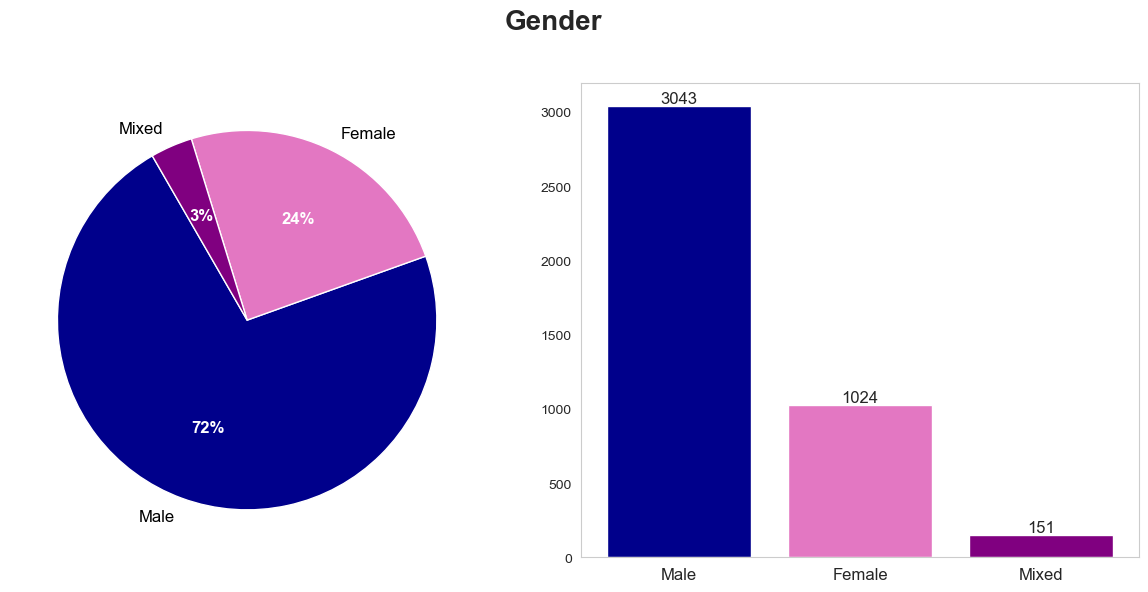

In [22]:
d = pd.concat((Data[2016][[32, 34]], Data[2017][[32, 34]], Data[2018][[32, 34]], Data[2019][[32, 34]]))

d = d[(d[34] != '-1') & (d[32] != '-1')]
d[32] = d[32].map({'Yes': 1, 'No': 0, 'Maybe': 0.5, 'Possibly': 0.5, "Don't Know": 0.5, '-1': 0.5})
d[34] = d[34].map({'Yes': 1, 'No': 0})

d.corr()


### Gender distribution

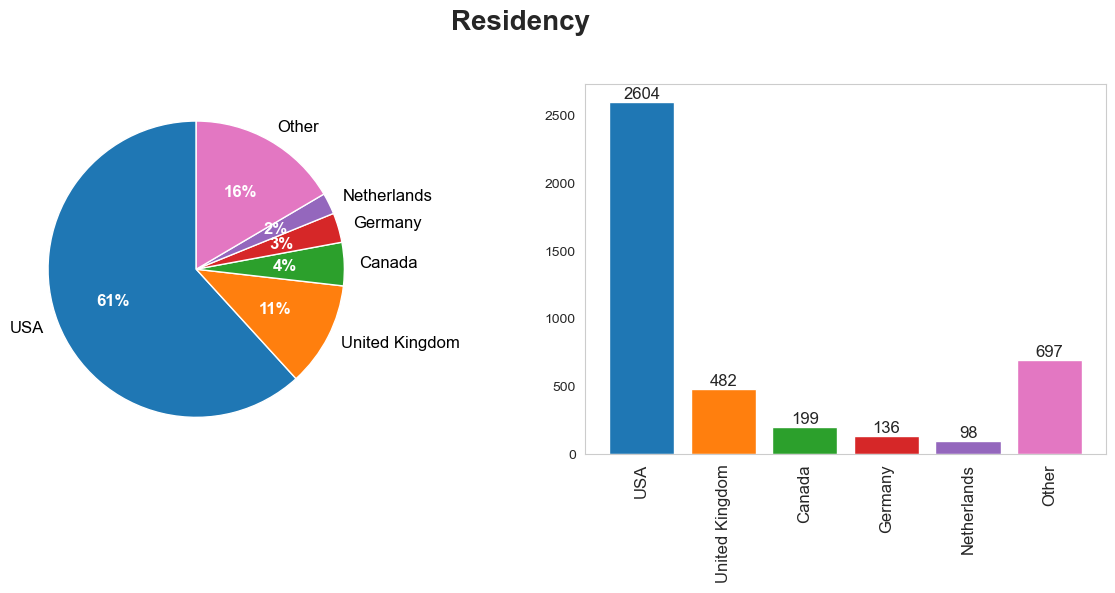

In [23]:
# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=2,
    nrows=1,
    dpi=100,
    figsize=(min(12, 4*n_cols), min(12, 3*n_rows))
)

axes = np.array(axes).flatten()

# Count the occurrences of each value
counts = pd.read_sql(
    '''
    SELECT AnswerText
    FROM Answer_upd
    WHERE QuestionID = 2
    ''',
    con
)['AnswerText'].value_counts()

colors = ['darkblue', '#e377c2', 'purple']

wedges, texts, autotexts = axes[0].pie(counts, labels=counts.index, autopct='%1i%%', startangle=120, colors=colors)
axes[0].set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(12)
    text.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

bars = axes[1].bar(counts.index, counts, color=colors)
axes[1].grid(False)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=12)

# Change font size of x-axis ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)

figure.suptitle(
    'Gender\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


### Residency distribution
#### By countries:

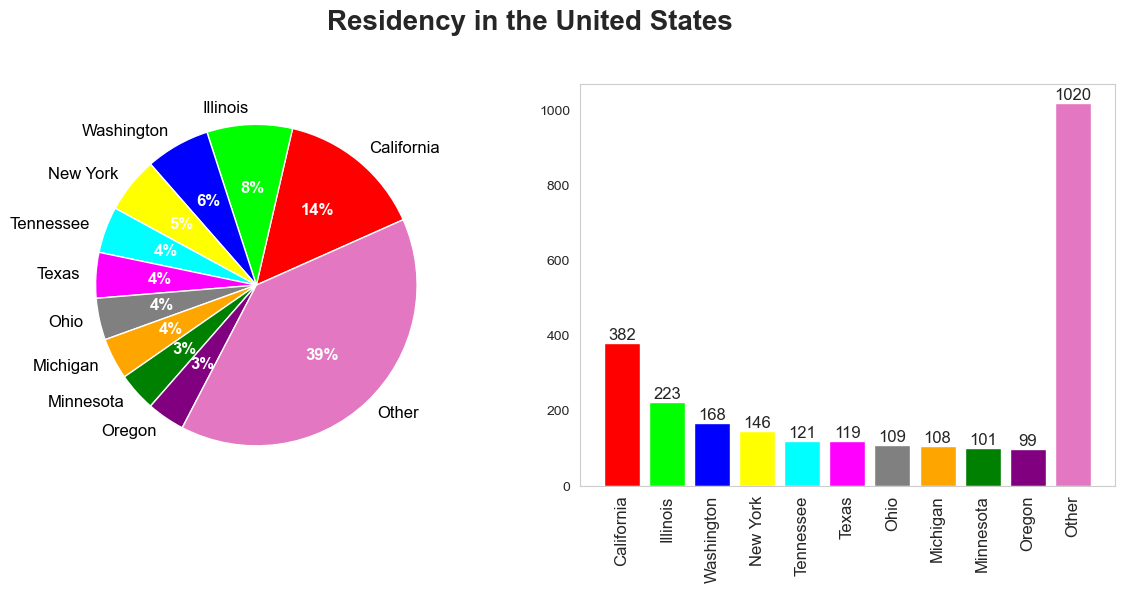

In [24]:
# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=2,
    nrows=1,
    dpi=100,
    figsize=(min(16, 4*n_cols), min(16, 3*n_rows))
)

axes = np.array(axes).flatten()

# Count the occurrences of each value
counts = pd.read_sql(
    '''
    SELECT AnswerText
    FROM Answer_upd
    WHERE QuestionID = 3 AND AnswerText <> '-1'
    ''',
    con
)['AnswerText'].value_counts()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#e377c2']

# Get the top 5 common values and their counts
top_5_values = counts.head(5)
other_count = counts.sum() - top_5_values.sum()

# Create a list of labels for the pie chart
labels = list(top_5_values.index) + ['Other']

# Create a list of values for the pie chart
values = list(top_5_values.values) + [other_count]

# Create the pie chart
wedges, texts, autotexts = axes[0].pie(values, labels=labels, autopct='%1i%%', startangle=90, colors=colors)
axes[0].set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(12)
    text.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

bars = axes[1].bar(labels, values, color=colors)
axes[1].grid(False)
axes[1].set_xticklabels(labels, rotation=90)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=12)

# Change font size of x-axis ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)

figure.suptitle(
    'Residency\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


#### Within the United States:

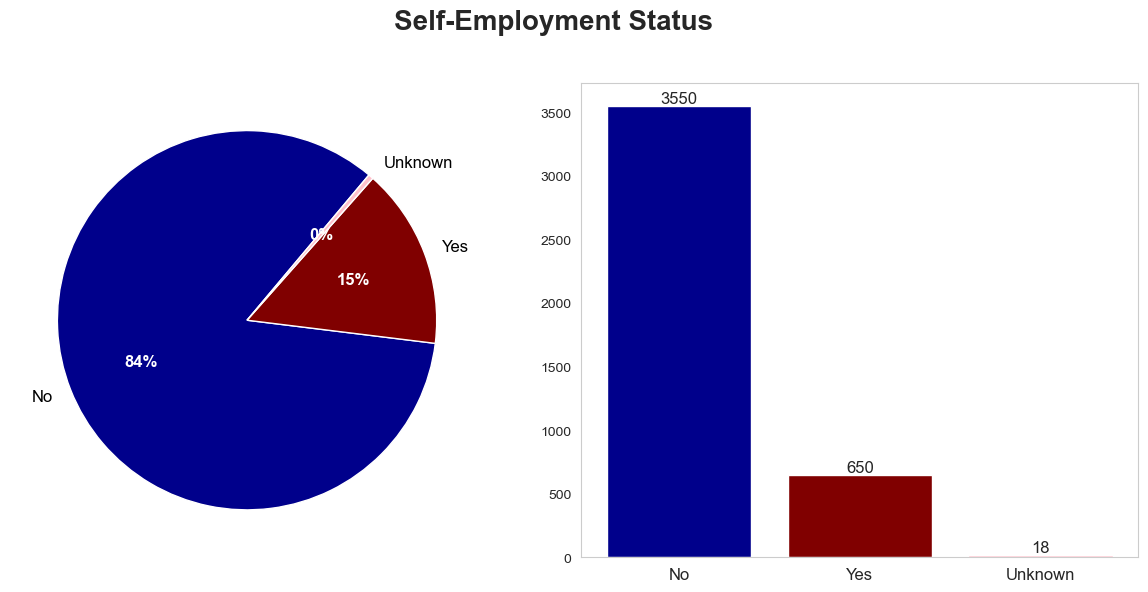

In [25]:
# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=2,
    nrows=1,
    dpi=100,
    figsize=(min(16, 4*n_cols), min(16, 3*n_rows))
)

axes = np.array(axes).flatten()

# Count the occurrences of each value
counts = pd.read_sql(
    '''
    SELECT AnswerText
    FROM Answer_upd
    WHERE QuestionID = 4 AND AnswerText <> '-1'
    ''',
    con
)['AnswerText'].value_counts()

colors = [
    '#FF0000',   # Red
    '#00FF00',   # Green
    '#0000FF',   # Blue
    '#FFFF00',   # Yellow
    '#00FFFF',   # Cyan
    '#FF00FF',   # Magenta
    '#808080',   # Gray
    '#FFA500',   # Orange
    '#008000',   # Dark Green
    '#800080',   # Purple
    '#E377C2'    # Pink
]

# Get the top 10 common states and their counts
top_10_values = counts.head(10)
other_count = counts.sum() - top_10_values.sum()

# Create a list of labels for the pie chart
labels = list(top_10_values.index) + ['Other']

# Create a list of values for the pie chart
values = list(top_10_values.values) + [other_count]

# Create the pie chart
wedges, texts, autotexts = axes[0].pie(values, labels=labels, autopct='%1i%%', startangle=24, colors=colors)
axes[0].set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(12)
    text.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

bars = axes[1].bar(labels, values, color=colors)
axes[1].grid(False)
axes[1].set_xticklabels(labels, rotation=90)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=12)

# Change font size of x-axis ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)

figure.suptitle(
    'Residency in the United States\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


### Self-Employment status

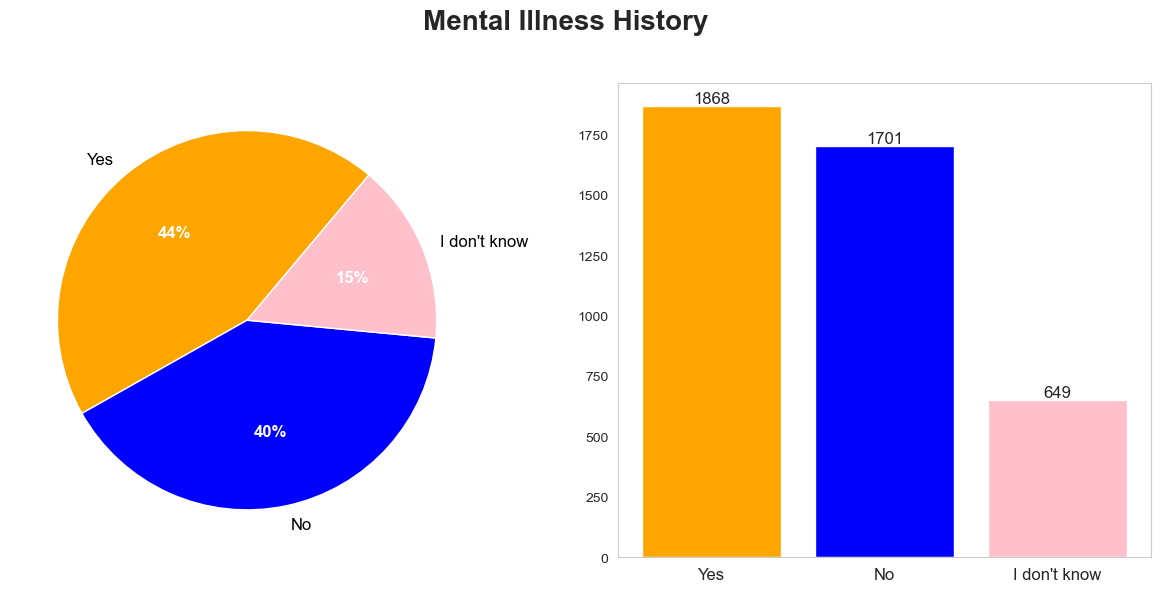

In [26]:
# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=2,
    nrows=1,
    dpi=100,
    figsize=(min(12, 4*n_cols), min(12, 3*n_rows))
)

axes = np.array(axes).flatten()

# Count the occurrences of each value
counts = pd.read_sql(
    '''
    SELECT AnswerText
    FROM Answer_upd
    WHERE QuestionID = 5
    ''',
    con
)['AnswerText'].value_counts()

labels = ['No', 'Yes', 'Unknown']

colors = ['darkblue', 'maroon', 'pink']

wedges, texts, autotexts = axes[0].pie(counts, labels=labels, autopct='%1i%%', startangle=50, colors=colors)
axes[0].set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(12)
    text.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

bars = axes[1].bar(labels, counts, color=colors)
axes[1].grid(False)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=12)

# Change font size of x-axis ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)

figure.suptitle(
    'Self-Employment Status\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


### History of mental illness

In [27]:
# Create a figure with subplots
figure, axes = plt.subplots(
    ncols=2,
    nrows=1,
    dpi=100,
    figsize=(min(12, 4*n_cols), min(12, 3*n_rows))
)

axes = np.array(axes).flatten()

# Count the occurrences of each value
counts = pd.read_sql(
    '''
    SELECT AnswerText
    FROM Answer_upd
    WHERE QuestionID = 6
    ''',
    con
)['AnswerText'].value_counts()

labels = counts.index

colors = ['orange', 'blue', 'pink']

wedges, texts, autotexts = axes[0].pie(counts, labels=labels, autopct='%1i%%', startangle=50, colors=colors)
axes[0].set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(12)
    text.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

bars = axes[1].bar(labels, counts, color=colors)
axes[1].grid(False)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=12)

# Change font size of x-axis ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)

figure.suptitle(
    'Mental Illness History\n',
    fontsize=20,
    fontweight='bold'
)
figure.subplots_adjust(hspace=0.2, wspace=0.2)
figure.tight_layout()

# Display the plot
plt.show()


Number of Observations: 4218; 
Number of Features: 12.
- Categorical features: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12; 
- Numerical features: .


QuestionID,1,2,3,4,5,6,7,8,9,10,11,12
UserID,,,,,,,,,,,,
1,37,Female,USA,Illinois,-1,No,1,6-25,1,Yes,Yes,No
2,44,Male,USA,Indiana,-1,No,0,More than 1000,0,Don't know,Don't know,No
3,32,Male,Canada,-1,-1,No,0,6-25,1,No,Don't know,Yes
4,31,Male,United Kingdom,-1,-1,Yes,1,26-100,1,No,No,Maybe
5,31,Male,USA,Texas,-1,No,0,100-500,1,Yes,Don't know,Yes
6,33,Male,USA,Tennessee,-1,Yes,0,6-25,1,Yes,Don't know,No
7,35,Female,USA,Michigan,-1,Yes,1,1-5,1,No,No,No
8,39,Male,Canada,-1,-1,No,0,1-5,1,No,Yes,No
9,42,Female,USA,Illinois,-1,Yes,1,100-500,1,Yes,No,No


###

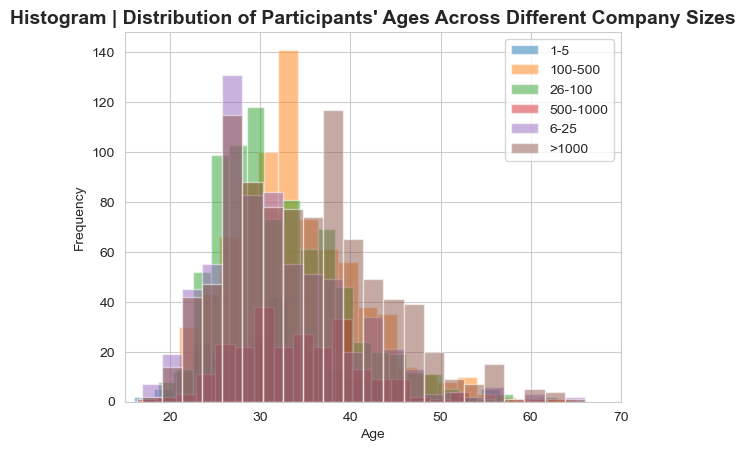

In [54]:
Data_personalInfo = pd.concat([Data[year][range(1, 13)] for year in years])
Data_personalInfo.head(10)

#####

#####

## Data Analysis


In [61]:
Data_model = pd.concat([Data[year][[33, 32, 1, 2, 6, 10, 15, 16, 23, 25, 26, 54, 55, 56]] for year in years[1:]])
Data_model.update_cols()
Data_model.recap()

Number of Observations: 2958; 
Number of Features: 14.
- Categorical features: ; 
- Numerical features: 33, 32, 1, 2, 6, 10, 15, 16, 23, 25, 26, 54, 55, 56.


QuestionID,33,32,1,2,6,10,15,16,23,25,26,54,55,56
UserID,,,,,,,,,,,,,,
1261,0.0,1.0,39,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0
1262,1.0,1.0,29,0.0,1.0,0,1,1,1.0,0.0,0.5,0.0,0.00,0.0
1263,0.0,0.5,38,0.0,0.0,0,0,0,0.0,0.0,0.5,0.0,0.00,0.0
1264,1.0,1.0,43,0.0,0.0,0,0,0,0.5,0.0,0.0,1.0,0.25,0.0
1265,1.0,1.0,43,1.0,1.0,1,0,0,0.0,0.5,0.0,0.0,0.00,1.0
1266,1.0,0.0,42,0.0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.00,1.0
1267,0.0,0.0,30,0.0,0.0,0,0,0,0.5,0.0,0.5,0.0,0.00,0.0
1268,1.0,1.0,37,1.0,1.0,1,0,1,0.5,0.5,0.5,0.0,0.00,0.5
1269,1.0,1.0,44,1.0,1.0,0,0,0,0.0,0.5,0.0,0.0,0.00,0.5


### Time-naive K-nearest neighbors
In this section, I will focus on the analysis of the survey data without considering the temporal dimension. This decision is justified by the assumption that the survey respondents are not the same individuals in different years, and that the time variable does not affect the classification model in a meaningful or consistent way. The classification model is a statistical technique that aims to assign each survey respondent to one of several predefined categories based on their answers to a set of questions. By excluding the survey periods as a predictor variable in the model, I aim to reduce the complexity and increase the generalizability of the model.

### Time-dependent K-nearest neighbors
In contrast to the previous section, where I ignored the temporal dimension of the surveys, in this section I will explore the possibility of using a time-dependent k-nearest neighbor classification model. The time-dependent k-nearest neighbor model incorporates the time variable as a feature in the classification process, and assigns different weights to data points depending on how recent they are. This way, the model can capture the temporal dynamics of the survey data and potentially improve the accuracy and relevance of the classification. I will compare the performance of this model with the one obtained in the previous section, where I used a standard classification model without considering the time variable.


## Interpretation of Results

## Suggestions and Recommendations